In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import KDTClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

# Simulation Data Generation


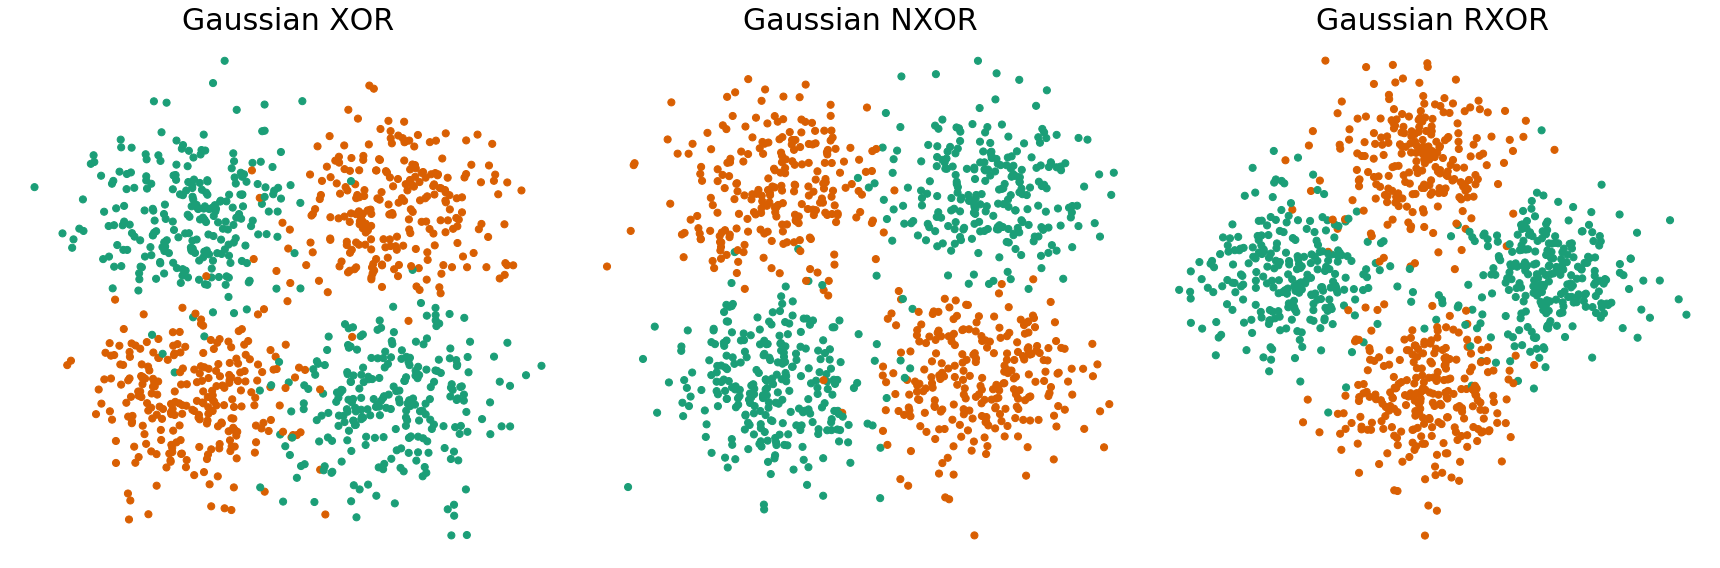

In [2]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_nxor, y_nxor = generate_gaussian_parity(1000, angle_params=np.pi/2)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi/4)

colors = sns.color_palette('Dark2', n_colors=2)

fig, ax = plt.subplots(1,3, figsize=(24,8))

clr = [colors[i] for i in y_xor]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Gaussian XOR', fontsize=30)
ax[0].axis('off')

clr = [colors[i] for i in y_nxor]
ax[1].scatter(X_nxor[:, 0], X_nxor[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Gaussian NXOR', fontsize=30)
ax[1].axis('off')

clr = [colors[i] for i in y_rxor]
ax[2].scatter(X_rxor[:, 0], X_rxor[:, 1], c=clr, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Gaussian RXOR', fontsize=30)
ax[2].axis('off')

plt.tight_layout()

# Experiment definition

In [3]:
def experiment(n_task1, n_task2, n_test=1000, 
               task1_angle=0, task2_angle=np.pi/2, 
               n_trees=10, max_depth=None, random_state=None):
    
    """
    A function to do progressive experiment between two tasks
    where the task data is generated using Gaussian parity.
    
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    
    n_task2 : int
        Total number of train dsample for task 2

    n_test : int, optional (default=1000)
        Number of test sample for each task.
        
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
            
    task2_angle : float, optional (default=numpy.pi/2)
        Angle in radian for task 2.
            
    n_trees : int, optional (default=10)
        Number of total trees to train for each task.

    max_depth : int, optional (default=None)
        Maximum allowable depth for each tree.
        
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        
    
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive UF error task1,
        naive UF task2.
    """

    if n_task1==0 and n_task2==0:
        raise ValueError('Wake up and provide samples to train!!!')

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6,dtype=float)

    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = KDTClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    naive_uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    if n_task1 == 0:
        progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

        errors[0] = 0.5
        errors[1] = 0.5

        uf_task2=progressive_learner.predict(test_task2,
                                             transformer_ids=[0], task_id=0)
        l2f_task2=progressive_learner.predict(test_task2, task_id=0)

        errors[2] = 1 - np.mean(uf_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)
        
        errors[4] = 0.5
        errors[5] = 1 - np.mean(uf_task2 == test_label_task2)
    elif n_task2 == 0:
        progressive_learner.add_task(X_task1, y_task1,
                                     num_transformers=n_trees)

        uf_task1=progressive_learner.predict(test_task1, 
                                             transformer_ids=[0], task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        
        errors[2] = 0.5
        errors[3] = 0.5
        
        errors[4] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
        progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

        uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
        uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)
        
        naive_uf_train_x = np.concatenate((X_task1,X_task2),axis=0)
        naive_uf_train_y = np.concatenate((y_task1,y_task2),axis=0)
        naive_uf.add_task(
                naive_uf_train_x, naive_uf_train_y, num_transformers=n_trees
                )
        
        uf_task1=uf.predict(test_task1, transformer_ids=[0], task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)
        uf_task2=uf.predict(test_task2, transformer_ids=[1], task_id=1)
        l2f_task2=progressive_learner.predict(test_task2, task_id=1)
        naive_uf_task1 = naive_uf.predict(
            test_task1, transformer_ids=[0], task_id=0
        )
        naive_uf_task2 = naive_uf.predict(
            test_task2, transformer_ids=[0], task_id=0
        )

        errors[0] = 1 - np.mean(
            uf_task1 == test_label_task1
        )
        errors[1] = 1 - np.mean(
            l2f_task1 == test_label_task1
        )
        errors[2] = 1 - np.mean(
            uf_task2 == test_label_task2
        )
        errors[3] = 1 - np.mean(
            l2f_task2 == test_label_task2
        )
        errors[4] = 1 - np.mean(
            naive_uf_task1 == test_label_task1
        )
        errors[5] = 1 - np.mean(
            naive_uf_task2 == test_label_task2
        )

    return errors


# Run experiment for XOR N-XOR tasks

In [29]:
mc_rep = 1000
n_test = 1000
n_trees = 10
n_xor = (100*np.arange(1.0, 7.50, step=0.50)).astype(int)
n_nxor = (100*np.arange(1.0, 7.50, step=0.50)).astype(int)

mean_error = np.zeros((6, len(n_xor)+len(n_nxor)))
std_error = np.zeros((6, len(n_xor)+len(n_nxor)))

mean_te = np.zeros((4, len(n_xor)+len(n_nxor)))
std_te = np.zeros((4, len(n_xor)+len(n_nxor)))

for i,n1 in enumerate(n_xor):
    print('starting to compute %s xor\n'%n1)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            n1,0,max_depth=ceil(log2(n1))
        ) for _ in range(mc_rep)
      )
    )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0])/np.mean(error[:,1])
    mean_te[1,i] = np.mean(error[:,2])/np.mean(error[:,3])
    mean_te[2,i] = np.mean(error[:,0])/np.mean(error[:,4])
    mean_te[3,i] = np.mean(error[:,2])/np.mean(error[:,5])
    

    if n1==n_xor[-1]:
        for j,n2 in enumerate(n_nxor):
            print('starting to compute %s nxor\n'%n2)
            
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(experiment)(
                    n1,n2,max_depth=ceil(log2(750))
                ) for _ in range(mc_rep)
              )
            )
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0])/np.mean(error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2])/np.mean(error[:,3])
            mean_te[2,i+j+1] = np.mean(error[:,0])/np.mean(error[:,4])
            mean_te[3,i+j+1] = np.mean(error[:,2])/np.mean(error[:,5])

with open('./plots/mean_xor_nxor.pickle','wb') as f:
    pickle.dump(mean_error,f)
    
with open('./plots/std_xor_nxor.pickle','wb') as f:
    pickle.dump(std_error,f)
    
with open('./plots/mean_te_xor_nxor.pickle','wb') as f:
    pickle.dump(mean_te,f)
    

starting to compute 100 xor



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 150 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 200 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 250 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s


starting to compute 300 xor



[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 350 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 400 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 450 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 500 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 550 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 600 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 650 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 700 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 100 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 150 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   23.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 200 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 250 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   27.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 300 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   29.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 350 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 400 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 450 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   31.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 500 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 550 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 600 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   33.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 650 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   33.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 700 nxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   33.9s finished


# Plot XOR N-XOR results

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


(-1.342662113720992,
 1.3265918751399761,
 -1.3933630756318258,
 1.4391776522593709)

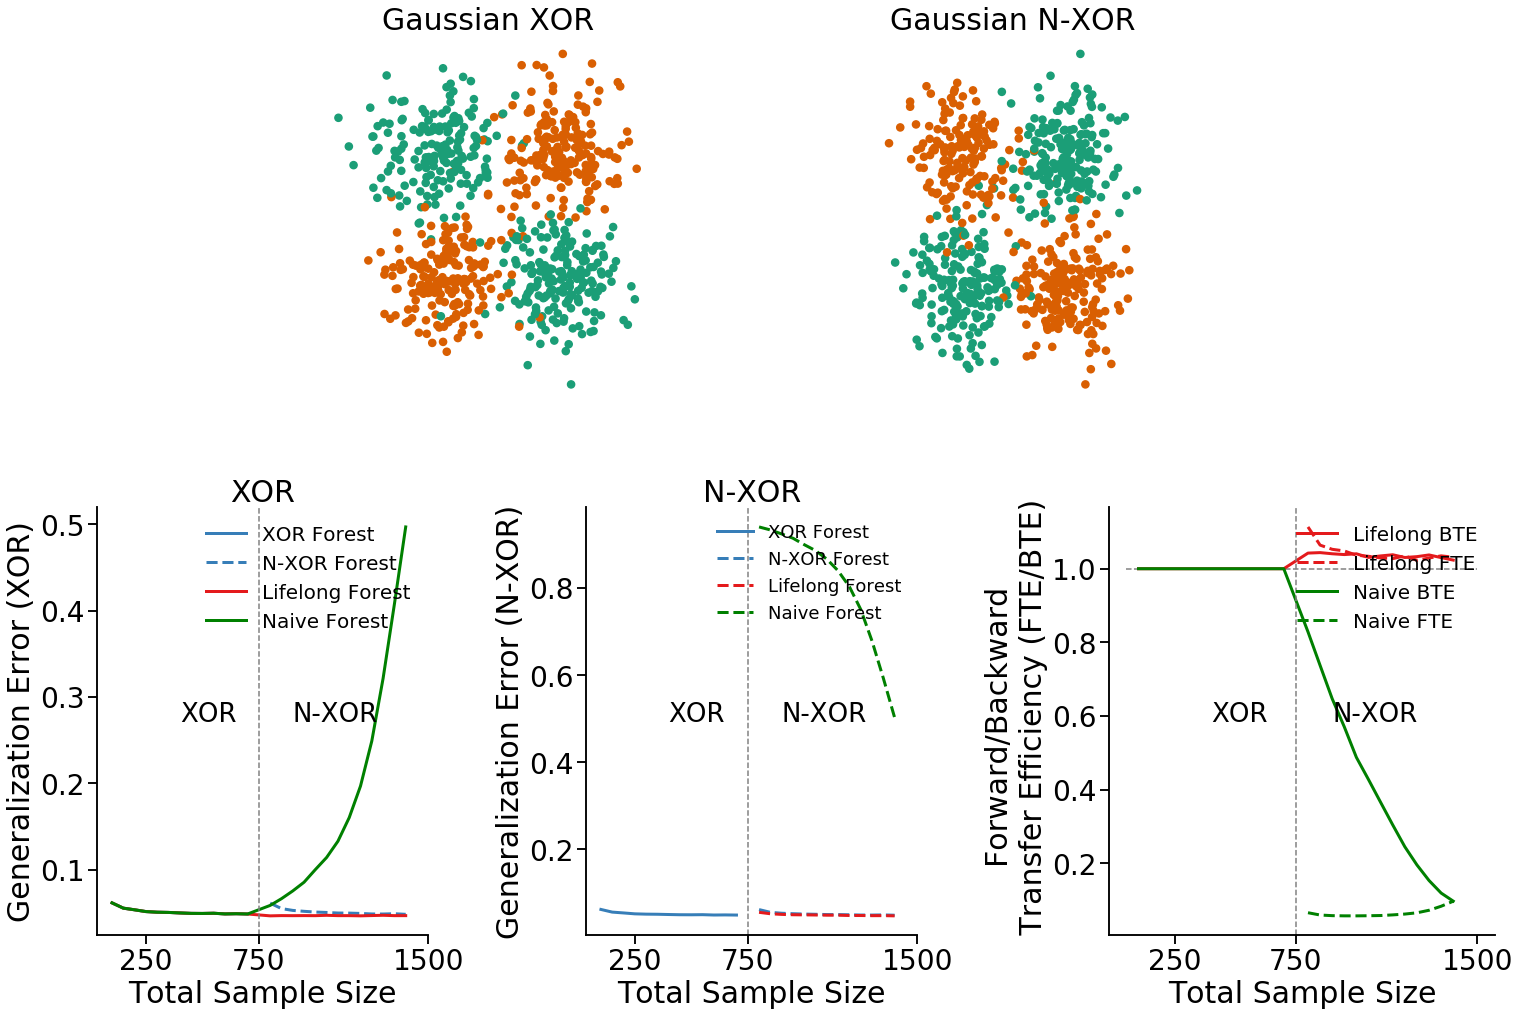

In [30]:
n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))
ls=['-', '--']
algorithms = ['XOR Forest', 'N-XOR Forest', 'Lifelong Forest', 'Naive Forest']


TASK1='XOR'
TASK2='N-XOR'

fontsize=30
labelsize=28

colors = sns.color_palette("Set1", n_colors = 2)

fig = plt.figure(constrained_layout=True,figsize=(21,14))
gs = fig.add_gridspec(14, 21)
ax1 = fig.add_subplot(gs[7:,:6])
ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)
ax1.plot(ns, mean_error[1], label=algorithms[2], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.plot(ns, mean_error[4], label=algorithms[3], c='g', ls=ls[np.sum(1 > 1).astype(int)], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
#ax1.set_ylim(0.09, 0.21)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0.5,0.15, 0.25])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
ax1.set_title('XOR', fontsize=30)

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

#####################################

algorithms = ['XOR Forest', 'N-XOR Forest', 'Lifelong Forest', 'Naive Forest']

TASK1='XOR'
TASK2='N-XOR'

ax1 = fig.add_subplot(gs[7:,7:13])
ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)

ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[2], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns[len(n1s):], mean_error[5, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=18, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")


right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

ax1.set_title('N-XOR', fontsize=30)

#####################################

algorithms = ['Lifelong BTE', 'Lifelong FTE', 'Naive BTE', 'Naive FTE']

TASK1='XOR'
TASK2='N-XOR'

ax1 = fig.add_subplot(gs[7:,14:])

ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns, mean_te[2], label=algorithms[2], c='g', ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[3, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

ax1.set_ylabel('Forward/Backward \n Transfer Efficiency (FTE/BTE)', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0,.5,1,1.5])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

colors = sns.color_palette('Dark2', n_colors=2)

X, Y = generate_gaussian_parity(750, angle_params=0)
Z, W = generate_gaussian_parity(750, angle_params=np.pi/2)

ax = fig.add_subplot(gs[:6,4:10])
clr = [colors[i] for i in Y]
ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian XOR', fontsize=30)

plt.tight_layout()
ax.axis('off')

colors = sns.color_palette('Dark2', n_colors=2)

ax = fig.add_subplot(gs[:6,11:16])
clr = [colors[i] for i in W]
ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian N-XOR', fontsize=30)
ax.axis('off')

# Run experiment for XOR R-XOR tasks

In [31]:
mc_rep = 1000
n_test = 1000
n_trees = 10
n_xor = (100*np.arange(1.0, 7.50, step=0.50)).astype(int)
n_rxor = (100*np.arange(1.0, 7.50, step=0.50)).astype(int)

mean_error = np.zeros((6, len(n_xor)+len(n_rxor)))
std_error = np.zeros((6, len(n_xor)+len(n_rxor)))

mean_te = np.zeros((4, len(n_xor)+len(n_rxor)))
std_te = np.zeros((4, len(n_xor)+len(n_rxor)))

for i,n1 in enumerate(n_xor):
    print('starting to compute %s xor\n'%n1)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            n1,0,task2_angle=np.pi/4,
            max_depth=ceil(log2(750))
        ) for _ in range(mc_rep)
      )
    )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0])/np.mean(error[:,1])
    mean_te[1,i] = np.mean(error[:,2])/np.mean(error[:,3])
    mean_te[2,i] = np.mean(error[:,0])/np.mean(error[:,4])
    mean_te[3,i] = np.mean(error[:,2])/np.mean(error[:,5])

    if n1==n_xor[-1]:
        for j,n2 in enumerate(n_rxor):
            print('starting to compute %s rxor\n'%n2)
            
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(experiment)(
                    n1,n2,task2_angle=np.pi/4,
                    max_depth=ceil(log2(750))
                ) for _ in range(mc_rep)
              )
            )
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0])/np.mean(error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2])/np.mean(error[:,3])
            mean_te[2,i+j+1] = np.mean(error[:,0])/np.mean(error[:,4])
            mean_te[3,i+j+1] = np.mean(error[:,2])/np.mean(error[:,5])

with open('./plots/mean_xor_rxor.pickle','wb') as f:
    pickle.dump(mean_error,f)
    
with open('./plots/std_xor_rxor.pickle','wb') as f:
    pickle.dump(std_error,f)
    
with open('./plots/mean_te_xor_rxor.pickle','wb') as f:
    pickle.dump(mean_te,f)

starting to compute 100 xor



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 150 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 200 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 250 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 300 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 350 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 400 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 450 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 500 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 550 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 600 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 650 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 700 xor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 100 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 150 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 200 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 250 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 300 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   22.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 350 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 400 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 450 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 500 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   27.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 550 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   28.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 600 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 650 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   31.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


starting to compute 700 rxor



[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.0s finished


# Plot XOR R-XOR results

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


(-1.4826561885183653,
 1.5512542618846916,
 -1.4817190839000767,
 1.4641375668423273)

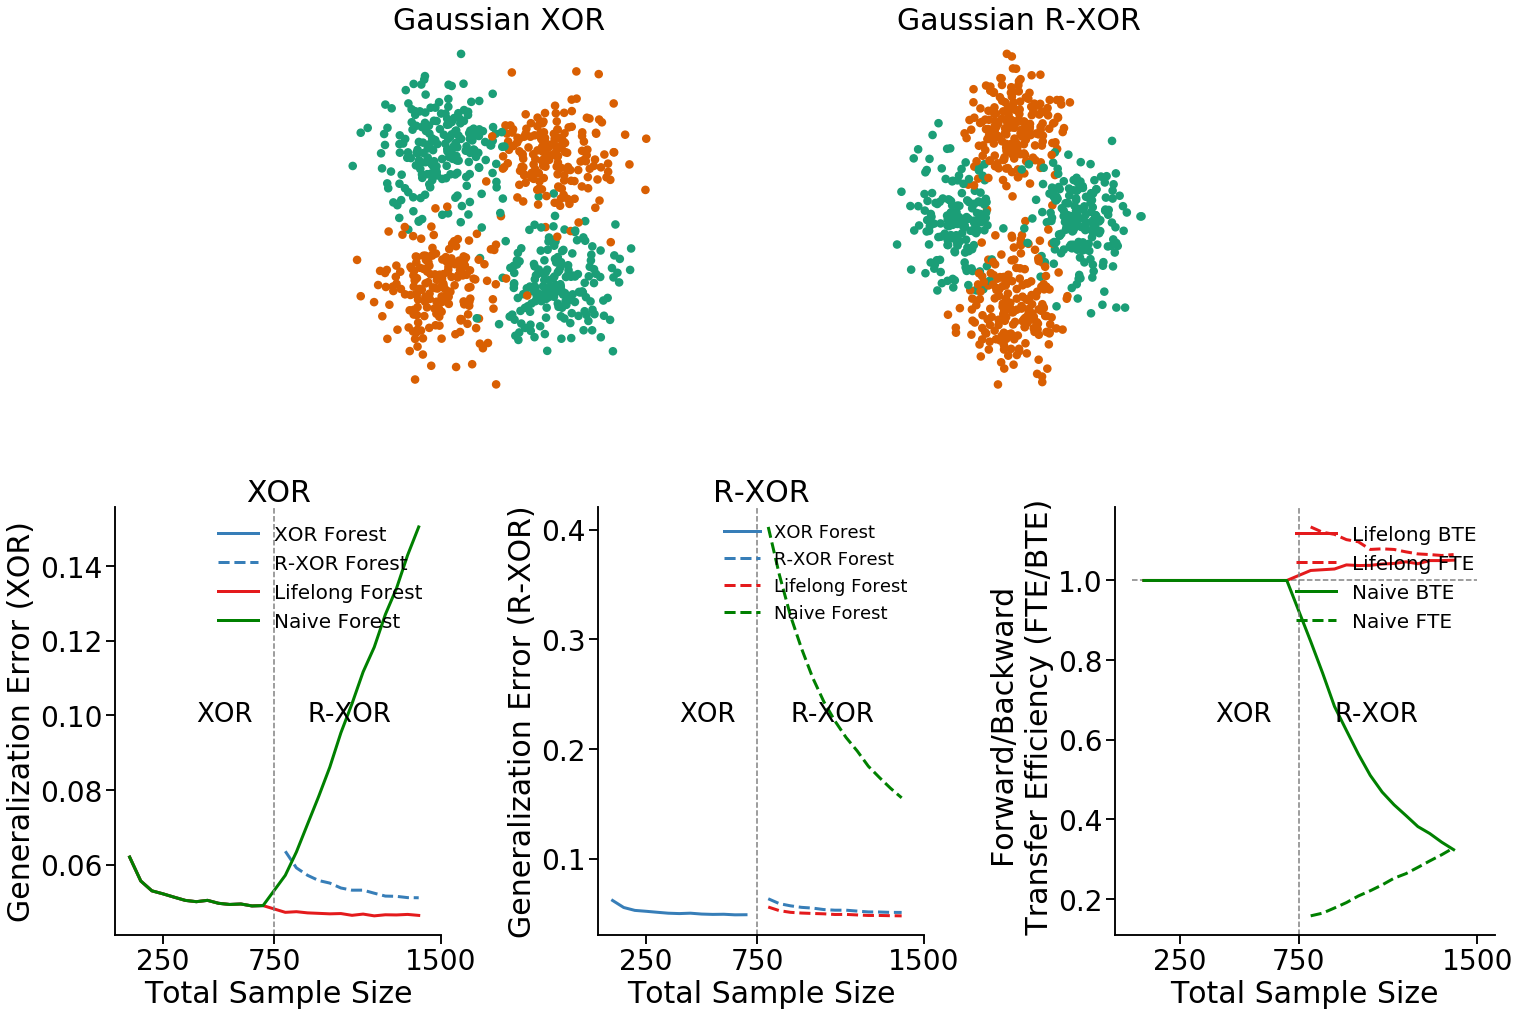

In [32]:
n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))
ls=['-', '--']
algorithms = ['XOR Forest', 'R-XOR Forest', 'Lifelong Forest', 'Naive Forest']


TASK1='XOR'
TASK2='R-XOR'

fontsize=30
labelsize=28

colors = sns.color_palette("Set1", n_colors = 2)

fig = plt.figure(constrained_layout=True,figsize=(21,14))
gs = fig.add_gridspec(14, 21)
ax1 = fig.add_subplot(gs[7:,:6])
ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)
ax1.plot(ns, mean_error[1], label=algorithms[2], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.plot(ns, mean_error[4], label=algorithms[3], c='g', ls=ls[np.sum(1 > 1).astype(int)], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
#ax1.set_ylim(0.09, 0.21)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0.1,0.15, 0.2])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
ax1.set_title('XOR', fontsize=30)

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

#####################################

algorithms = ['XOR Forest', 'R-XOR Forest', 'Lifelong Forest', 'Naive Forest']

TASK1='XOR'
TASK2='R-XOR'

ax1 = fig.add_subplot(gs[7:,7:13])
ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)

ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[2], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns[len(n1s):], mean_error[5, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=18, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")


right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

ax1.set_title('R-XOR', fontsize=30)

#####################################

algorithms = ['Lifelong BTE', 'Lifelong FTE', 'Naive BTE', 'Naive FTE']

TASK1='XOR'
TASK2='R-XOR'

ax1 = fig.add_subplot(gs[7:,14:])

ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns, mean_te[2], label=algorithms[2], c='g', ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[3, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

ax1.set_ylabel('Forward/Backward \n Transfer Efficiency (FTE/BTE)', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0,.5,1,1.5])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

colors = sns.color_palette('Dark2', n_colors=2)

X, Y = generate_gaussian_parity(750, angle_params=0)
Z, W = generate_gaussian_parity(750, angle_params=np.pi/4)

ax = fig.add_subplot(gs[:6,4:10])
clr = [colors[i] for i in Y]
ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian XOR', fontsize=30)

plt.tight_layout()
ax.axis('off')

colors = sns.color_palette('Dark2', n_colors=2)

ax = fig.add_subplot(gs[:6,11:16])
clr = [colors[i] for i in W]
ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian R-XOR', fontsize=30)
ax.axis('off')

# Experiment for Backward Transfer Efficiency (BTE) vs. angle of rotation for the second task

In [33]:
###main hyperparameters###
angle_sweep = range(0,90,1)
task1_sample = 100
task2_sample = 100
mc_rep = 5000

mean_te = np.zeros(len(angle_sweep), dtype=float)
for ii,angle in enumerate(angle_sweep):
    print("Progress: {:2.2f}%".format(100 * ii / len(angle_sweep)))
    error = np.array(
        Parallel(n_jobs=-1,verbose=0)(
        delayed(experiment)(
            task1_sample,task2_sample,
            task2_angle=angle*np.pi/180, 
            max_depth=ceil(log2(task1_sample))
        ) for _ in range(mc_rep)
      )
    )

    mean_te[ii] = np.mean(error[:,0])/np.mean(error[:,1])

with open('./plots/mean_angle_te.pickle','wb') as f:
    pickle.dump(mean_te,f)


Progress: 0.00%
Progress: 1.11%
Progress: 2.22%
Progress: 3.33%
Progress: 4.44%
Progress: 5.56%
Progress: 6.67%
Progress: 7.78%
Progress: 8.89%
Progress: 10.00%
Progress: 11.11%
Progress: 12.22%
Progress: 13.33%
Progress: 14.44%
Progress: 15.56%
Progress: 16.67%
Progress: 17.78%
Progress: 18.89%
Progress: 20.00%
Progress: 21.11%
Progress: 22.22%
Progress: 23.33%
Progress: 24.44%
Progress: 25.56%
Progress: 26.67%
Progress: 27.78%
Progress: 28.89%
Progress: 30.00%
Progress: 31.11%
Progress: 32.22%
Progress: 33.33%
Progress: 34.44%
Progress: 35.56%
Progress: 36.67%
Progress: 37.78%
Progress: 38.89%
Progress: 40.00%
Progress: 41.11%
Progress: 42.22%
Progress: 43.33%
Progress: 44.44%
Progress: 45.56%
Progress: 46.67%
Progress: 47.78%
Progress: 48.89%
Progress: 50.00%
Progress: 51.11%
Progress: 52.22%
Progress: 53.33%
Progress: 54.44%
Progress: 55.56%
Progress: 56.67%
Progress: 57.78%
Progress: 58.89%
Progress: 60.00%
Progress: 61.11%
Progress: 62.22%
Progress: 63.33%
Progress: 64.44%
Progre

# Plot the result

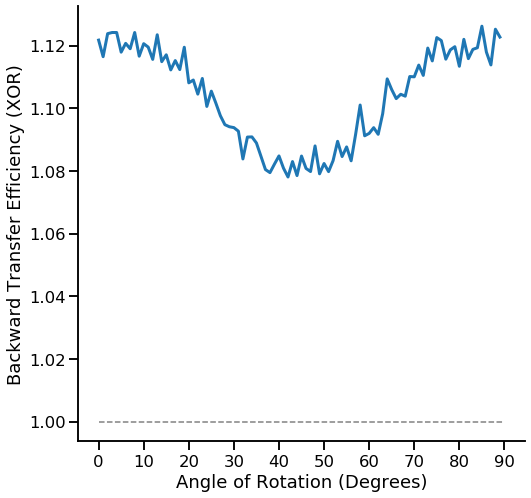

In [34]:
angle_sweep = range(0,90,1)

sns.set_context("talk")
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(angle_sweep,mean_te,linewidth = 3)
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)


# Experiment for Backward Transfer Efficiency (BTE) vs. number of training samples for the second task

In [36]:
###main hyperparameters###
task2_sample_sweep = (2**np.arange(np.log2(110), np.log2(5010)+1, .50)).astype('int')
task1_sample = 500
task2_angle = 25*np.pi/180
mc_rep = 5000

mean_te = np.zeros(len(task2_sample_sweep), dtype=float)
for ii,sample_no in enumerate(task2_sample_sweep):
    print("Progress: {:2.2f}%".format(100 * ii / len(task2_sample_sweep)))
    error = np.array(
        Parallel(n_jobs=-1,verbose=0)(
        delayed(experiment)(
            task1_sample,sample_no,
            task2_angle=task2_angle, 
            max_depth=10
        ) for _ in range(mc_rep)
      )
    )

    mean_te[ii] = np.mean(error[:,0])/np.mean(error[:,1])

with open('./plots/mean_sample_te.pickle','wb') as f:
    pickle.dump(mean_te,f)

Progress: 0.00%
Progress: 7.14%
Progress: 14.29%
Progress: 21.43%
Progress: 28.57%
Progress: 35.71%
Progress: 42.86%
Progress: 50.00%
Progress: 57.14%
Progress: 64.29%
Progress: 71.43%
Progress: 78.57%
Progress: 85.71%
Progress: 92.86%


# Plot the result

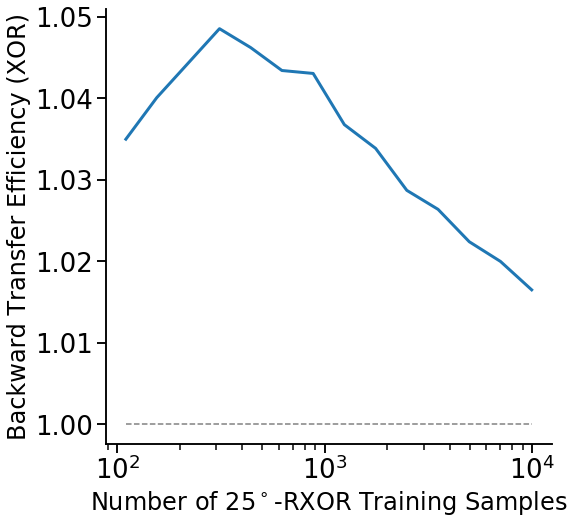

In [49]:
sns.set_context("talk")
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(task2_sample_sweep,mean_te,linewidth = 3)
ax.hlines(1, np.min(task2_sample_sweep),np.max(task2_sample_sweep), colors='gray', linestyles='dashed',linewidth=1.5)
ax.set_xscale('log')
ax.tick_params(labelsize=26)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


ax.set_xlabel("Number of $25^\circ$-RXOR Training Samples", fontsize=24)
ax.set_ylabel('Backward Transfer Efficiency (XOR)',fontsize=24)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)